# Set System Path

In [2]:
import sys
import os

sys_path = os.path.dirname(os.getcwd())
print(sys_path)
sys.path.append(sys_path)
os.chdir(sys_path)

/Users/shikaiyi/Desktop/Ncku/MedicalImage/final


# Segment Blood Vessels

In [3]:
import cv2
from retina_features.bloodvessels import extract_bv

In [3]:
pathFolder = "data/Sample_imgs/BRVO"
filesArray = [x for x in os.listdir(pathFolder) if os.path.isfile(os.path.join(pathFolder,x))]
destinationFolder = "data/Sample_imgs/BRVO_processed/"

In [5]:
for file_name in filesArray:
    file_name_no_extension = os.path.splitext(file_name)[0]
    fundus = cv2.imread(pathFolder + '/' + file_name)		
    bloodvessel = extract_bv(fundus)
    cv2.imwrite(destinationFolder + file_name_no_extension + "_bloodvessel.png", bloodvessel)

- 看起來 670, 734, 982, 1009, 1289 都不錯，血管辨識明確且出血明顯
- 選 734 好了

# Circle BRVO

In [4]:
import numpy as np
from PIL import Image
from skimage import util

from common import plot_image, compare_plots

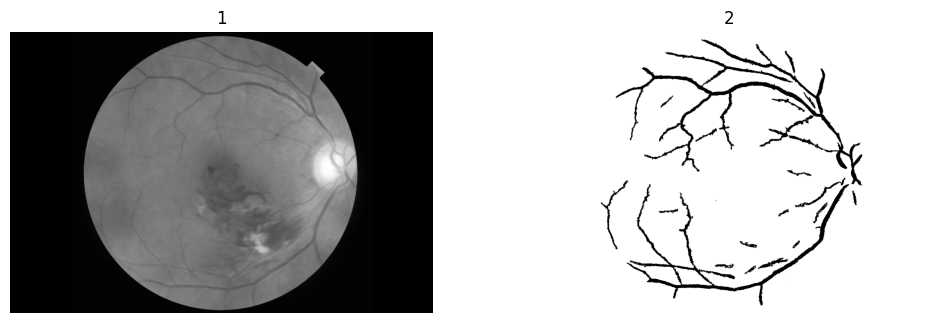

In [5]:
original_path = 'data/Sample_imgs/BRVO/734.png'
original_img = Image.open(original_path)
gray_original_img = original_img.convert('L')

blood_vessel_path = 'data/Sample_imgs/BRVO_processed/734_bloodvessel.png'
blood_vessel_img = Image.open(blood_vessel_path)
gray_blood_vessel_img = blood_vessel_img.convert('L')

compare_plots(gray_original_img, gray_blood_vessel_img)

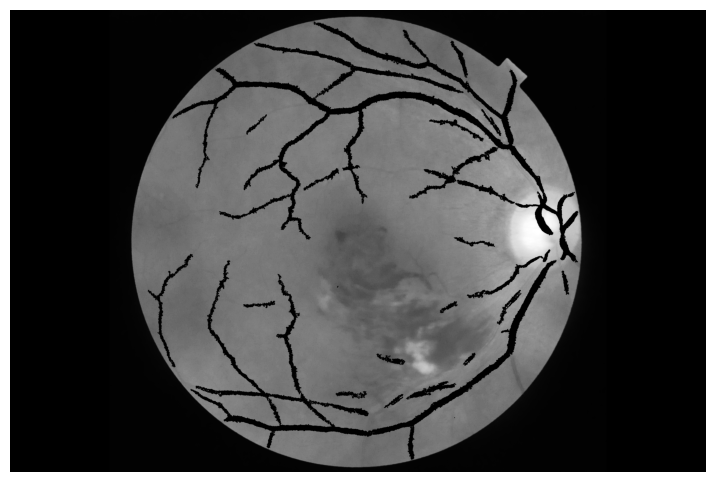

In [6]:
inverted_blood_vessel_img = util.invert(np.array(gray_blood_vessel_img))
subtracted_img = np.clip(np.array(gray_original_img, dtype=np.int16) - inverted_blood_vessel_img, 0, 255).astype(np.uint8)
plot_image(subtracted_img)

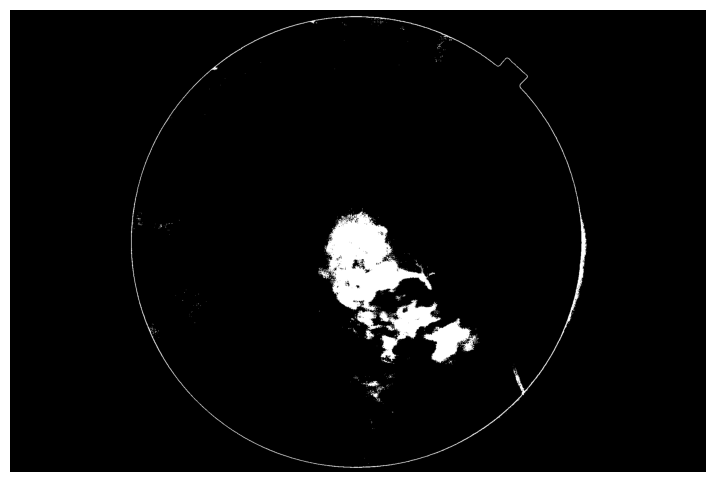

In [7]:
lighter_mask = subtracted_img > 10
darker_mask = subtracted_img < 89

# Combine both masks using a bitwise AND operation to get the final BRVO area
brvo_area_mask = np.bitwise_and(lighter_mask, darker_mask)

plot_image(brvo_area_mask)

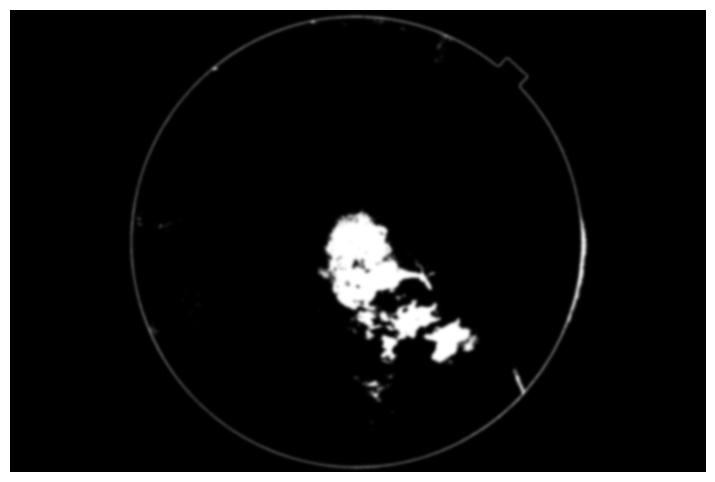

In [9]:
brvo_area_mask_uint8 = brvo_area_mask.astype(np.uint8) * 255
blurred_image = cv2.GaussianBlur(brvo_area_mask_uint8, (27, 27), 0)
plot_image(blurred_image)

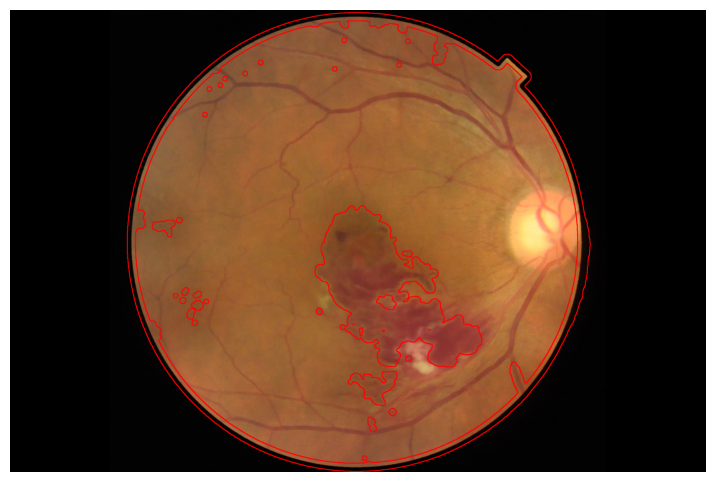

In [10]:
contours, _ = cv2.findContours(blurred_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
original_image_array = np.array(original_img)
cv2.drawContours(original_image_array, contours, -1, (255, 0, 0), 2)  # Red color contours with thickness of 2

# Convert array back to image for display
contoured_original_image = Image.fromarray(original_image_array)
plot_image(contoured_original_image)

In [11]:
def distance_from_center(point, center):
    return np.sqrt((point[0] - center[0]) ** 2 + (point[1] - center[1]) ** 2)

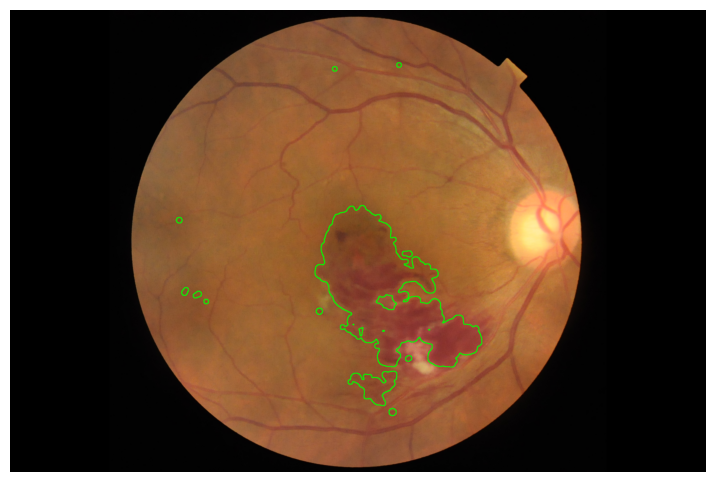

In [14]:
image_center = (original_img.size[0] // 2, original_img.size[1] // 2)
distance_threshold = 2 * original_img.size[1] // 5

filtered_contours = []
for contour in contours:
    if all(distance_from_center(pt[0], image_center) < distance_threshold for pt in contour):
        filtered_contours.append(contour)

original_with_contours = np.array(original_img).copy()
cv2.drawContours(original_with_contours, filtered_contours, -1, (0, 255, 0), 2)

plot_image(original_with_contours)